In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


######################################################
################### TENSORBOARD ######################
######################################################

writer = SummaryWriter('runs/Face_Detect')

######################################################

cuda


In [2]:
transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize(32),             
        transforms.CenterCrop(32),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform = None):
        self.data = datasets.ImageFolder(root, transform = transform)
        self.classes = self.data.classes
        self.num_classes = len(self.classes)
    def __getitem__(self, index):
        img, label = self.data[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        return img, one_hot_label   
    
    def __len__(self):
            return len(self.data)
        
        
x_train = FaceDataset( root=("/kaggle/input/face-class/Face/Train"), transform = transform)
x_val = FaceDataset(root = ('/kaggle/input/face-class/Face/Val'), transform = transform)

In [3]:
print("Tổng class: ",len(x_train.classes))
print("Tên các loại: ",x_train.classes)
class_name = ['Cao Minh Quan', 'Huynh Anh Duy', 'Le Tri Dung', 'Nguyen Hai Hoang', 'Nguyen Ngoc Nhan']

batch = 128
epochs = 12
learning_rate = 1e-3
weight_decay = 1e-4

train_loader = DataLoader(x_train, batch_size = batch, shuffle = True)
val_loader = DataLoader(x_val, batch_size = batch, shuffle = True)

examples = iter(val_loader)
example_data, example_targets = next(examples)

######################################################
################### TENSORBOARD ######################
######################################################

img_grid = torchvision.utils.make_grid(example_data)
writer.add_image("Face",img_grid)
writer.close()

######################################################

Tổng class:  5
Tên các loại:  ['CaoMinhQuan', 'HuynhAnhDUy', 'LeTriDung', 'NguyenHaiHoang', 'NguyenNgocNhan']


In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
#     self.relu = F.leaky_relu()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(3,32,3,stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32,64,3,stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64,128,3,stride = 1, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.dropout = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(7*7*128, 124)
    self.fc2 = nn.Linear(124,32)
    self.fc3 = nn.Linear(32, 6)
    
  def forward(self, x):
    x = self.maxpool(F.leaky_relu(self.conv1(x)))
    x = self.maxpool(F.leaky_relu(self.conv2(x)))
    x = self.maxpool(F.leaky_relu(self.conv3(x)))
    x = self.avgpool(x)
    x = x.view(-1, 7*7*128)
    x = self.dropout(F.leaky_relu(self.fc1(x)))
    x = self.dropout(F.leaky_relu(self.fc2(x)))
    x = self.fc3(x)

    return x

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

######################################################
################### TENSORBOARD ######################
######################################################

writer.add_graph(model, example_data.to(device))
writer.close()

######################################################

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    864     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |   777728   |
|   fc1.bias   |    124     |
|  fc2.weight  |    3968    |
|   fc2.bias   |     32     |
|  fc3.weight  |    192     |
|   fc3.bias   |     6      |
+--------------+------------+
Total Trainable Params: 875298


875298

In [6]:
n_total_steps = len(train_loader)

run_loss = 0.0
run_acc = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.reshape(-1,3,32,32).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        outputs = model(images)

        loss = criterion(outputs,labels)
        
        run_loss +=loss.item() #for tensorboard
        _,pred = torch.max(outputs.data, 1)
        run_acc += (pred==labels).sum().item()#for tensorboard
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2 == 0:
            
            ############################## Check validation_data ###################################
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(5)]
                n_class_samples = [0 for i in range(5)]
                
                for images_val, labels_val in val_loader:
                    images_val = images_val.reshape(-1,3,32,32).to(device)
                    labels_val = labels_val.to(device)
                    _, labels_val = torch.max(labels_val.data, 1)
                    
                    output_val = model(images_val)
                    _, predict_val = torch.max(output_val.data, 1)
                    n_samples += labels_val.size(0)
                    n_correct += (predict_val == labels_val).sum().item()
                    loss_val = F.mse_loss(labels_val.float(),predict_val.float())
                    for i in range(26):
                        label_val = labels_val[i]
                        pred_val = predict_val[i]
                        if label_val == pred_val:
                            n_class_correct[label_val] += 1
                            
                        n_class_samples[label_val] += 1
                        
                acc_val = n_correct/(n_samples)
                
                acc_total = run_acc/((2-1)*128+pred.size(0))
                print(f'Epoch[{epoch+1}/{epochs}]:  Loss_Train: {(run_loss/2):.2f}, Acc_Train: {acc_total:.2f}, Loss_Val: {loss_val:.2f}, Acc_Val: {acc_val:.2f}')
            
            
            ################################################################################################################
            #################################################### TENSORBOARD ###############################################
            ################################################################################################################           
            writer.add_scalars("Do Mat Mat Cua: ", {'Loss': run_loss/2, 'Loss_valid':loss_val}, epoch*n_total_steps+i)
            writer.add_scalars('Do Chinh Xac Cua: ', {'Accuracy':acc_total,'Accuracy_valid':acc_val}, epoch*n_total_steps+i)
            
            run_loss = 0.0
            run_acc = 0.0
            ################################################################################################################           

print('Finished Training')

100%|██████████| 2/2 [00:22<00:00, 11.44s/it]


Epoch[1/12]:  Loss_Train: 1.74, Acc_Train: 0.18, Loss_Val: 4.47, Acc_Val: 0.16


100%|██████████| 2/2 [00:17<00:00,  8.71s/it]


Epoch[2/12]:  Loss_Train: 1.54, Acc_Train: 0.29, Loss_Val: 3.37, Acc_Val: 0.33


100%|██████████| 2/2 [00:17<00:00,  8.67s/it]


Epoch[3/12]:  Loss_Train: 1.34, Acc_Train: 0.39, Loss_Val: 2.08, Acc_Val: 0.51


100%|██████████| 2/2 [00:16<00:00,  8.37s/it]


Epoch[4/12]:  Loss_Train: 1.05, Acc_Train: 0.62, Loss_Val: 1.67, Acc_Val: 0.63


100%|██████████| 2/2 [00:17<00:00,  8.90s/it]


Epoch[5/12]:  Loss_Train: 0.78, Acc_Train: 0.79, Loss_Val: 0.37, Acc_Val: 0.75


100%|██████████| 2/2 [00:17<00:00,  8.57s/it]


Epoch[6/12]:  Loss_Train: 0.51, Acc_Train: 0.82, Loss_Val: 0.27, Acc_Val: 0.84


100%|██████████| 2/2 [00:17<00:00,  8.90s/it]


Epoch[7/12]:  Loss_Train: 0.40, Acc_Train: 0.87, Loss_Val: 0.49, Acc_Val: 0.78


100%|██████████| 2/2 [00:17<00:00,  8.88s/it]


Epoch[8/12]:  Loss_Train: 0.34, Acc_Train: 0.88, Loss_Val: 0.22, Acc_Val: 0.84


100%|██████████| 2/2 [00:17<00:00,  8.54s/it]


Epoch[9/12]:  Loss_Train: 0.24, Acc_Train: 0.89, Loss_Val: 0.18, Acc_Val: 0.82


100%|██████████| 2/2 [00:17<00:00,  8.84s/it]


Epoch[10/12]:  Loss_Train: 0.12, Acc_Train: 0.93, Loss_Val: 0.12, Acc_Val: 0.88


100%|██████████| 2/2 [00:17<00:00,  8.64s/it]


Epoch[11/12]:  Loss_Train: 0.11, Acc_Train: 0.95, Loss_Val: 0.25, Acc_Val: 0.90


100%|██████████| 2/2 [00:17<00:00,  8.79s/it]

Epoch[12/12]:  Loss_Train: 0.08, Acc_Train: 0.96, Loss_Val: 0.08, Acc_Val: 0.92
Finished Training


In [7]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    
    for images, labels in val_loader:
        images = images.reshape(-1,3,32,32).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        output = model(images)
        
        _, predict = torch.max(output.data, 1)
        n_samples += labels.size(0)
        n_correct += (predict == labels).sum().item()
        
        for i in range(51):
            label = labels[i]
            pred = predict[i]
            if label == pred:
                n_class_correct[label] +=1
                
            n_class_samples[label]+=1
            
    acc = 100.0*n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 92.15686274509804 %


In [8]:
# Save model
FILE = "model_face.pth"
torch.save(model.state_dict(), FILE)


# Load model
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

CNN(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=6272, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6, bias=True)
)

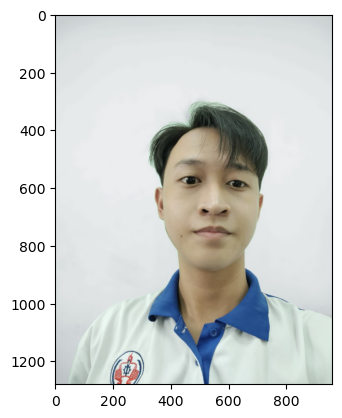

Nguyen Ngoc Nhan


In [9]:
from torchvision import transforms
import PIL.Image as Image

url = '/kaggle/input/face-class/Face/Test/NguyenNgocNhan.jpg'
# Load ảnh
img = Image.open(url)


# Hiển thị ảnh
plt.imshow(img)
plt.show()
# Áp dụng transform

img_transformed = transform(img)


# App load model
test = loaded_model(img_transformed.to(device))
print(class_name[torch.max(test.data,1)[1].data])

In [10]:
!zip -r abc.zip /kaggle/working/runs

  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/Do Chinh Xac Cua: _Accuracy/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/Do Chinh Xac Cua: _Accuracy/events.out.tfevents.1683076735.c4cb11970417.24.5 (deflated 52%)
  adding: kaggle/working/runs/Face_Detect/Do Mat Mat Cua: _Loss/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/Do Mat Mat Cua: _Loss/events.out.tfevents.1683076735.c4cb11970417.24.3 (deflated 52%)
  adding: kaggle/working/runs/Face_Detect/events.out.tfevents.1683076735.c4cb11970417.24.2 (deflated 5%)
  adding: kaggle/working/runs/Face_Detect/Do Chinh Xac Cua: _Accuracy_valid/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/Do Chinh Xac Cua: _Accuracy_valid/events.out.tfevents.1683076735.c4cb11970417.24.6 (deflated 53%)
  adding: kaggle/working/runs/Face_Detect/Do Mat Mat Cua: _Loss_valid/ (stored 0%)
  adding: kaggle/working/runs/Face_Detect/Do Mat Mat Cua: _Loss